In [1]:
import numpy as np
import os
import sys
import cv2
from skimage import io
from matplotlib import pyplot as plt
import random
from time import time
from tqdm import tqdm, tqdm_notebook
import face_alignment as fal
import dlib
from math import sqrt
from skimage.measure import find_contours

In [159]:
img = io.imread('../apmat/data/images_data/00049.jpg')
H, W, D = img.shape

In [66]:
img = io.imread('../fal/fal_input/21719.png')

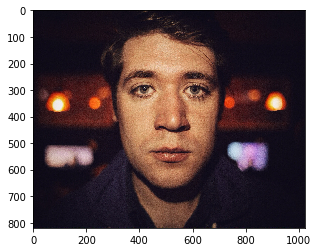

In [160]:
plt.imshow(img)
plt.show()

### FAL landmarks

In [4]:
fa = fal.FaceAlignment(fal.LandmarksType._2D, flip_input=False)

In [5]:
preds = fa.get_landmarks(img)

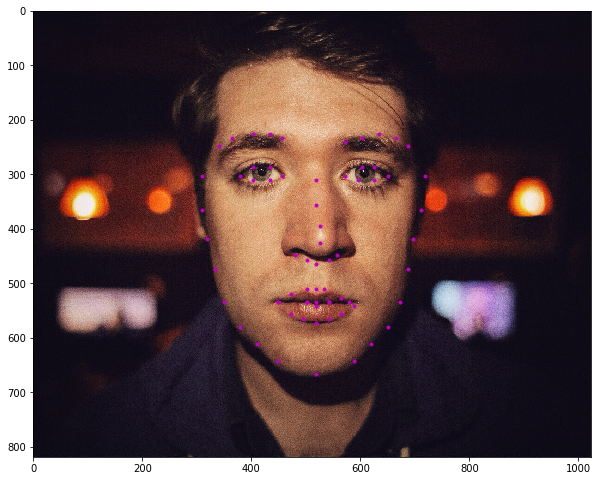

In [6]:
for pts in preds:
    fig = plt.figure(figsize=(10,10))
#     plt.imshow(np.flip(img,2))
    plt.imshow(img)
    plt.scatter(pts[:68,0], pts[:68,1], marker='.', c='m')
plt.show()

0:17 - контур

17:27 - брови 

27:31 - нос верт.

31:36 - нос гор.

36:42 - левый глаз

42:48 - правый глаз

48:60 - внешний контур губ

60:68 - внутренний контур губ (тоже с углами)

68:75 - линия лба

In [4]:
lips_left_idx = (48,49,50,51,57,58,59,60,61,62,66,67)
lips_right_idx = (51,52,53,54,55,56,57,62,63,64,65,66)

### Dlib landmarks

In [161]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

In [162]:
dets = detector(img, 1)

In [163]:
parts = predictor(img, dets[0]).parts()

In [164]:
dlib_pts = []
for pt in parts:
    dlib_pts.append(np.array([pt.x, pt.y]))
dlib_pts = np.array(dlib_pts)

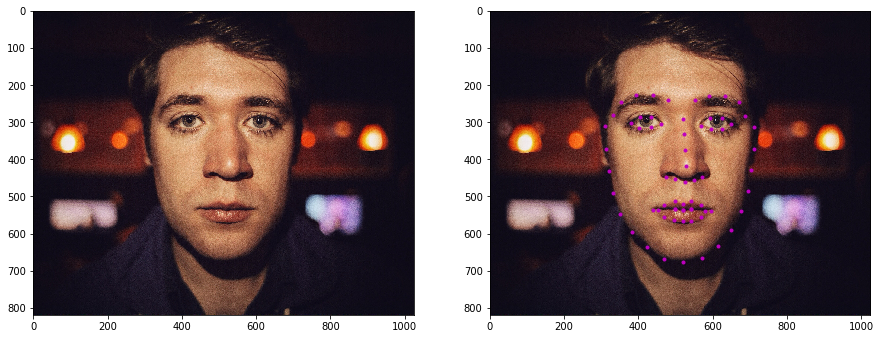

In [165]:
fig = plt.figure(figsize=(15,15))
fig.add_subplot(121)
plt.imshow(img)
# plt.scatter(preds[0][:,0], preds[0][:,1], marker='.', c='m')
fig.add_subplot(122)
plt.imshow(img)
plt.scatter(dlib_pts[:,0], dlib_pts[:,1], marker='.', c='m')
plt.show()

### Triangulation visualisation

In [10]:
def rect_contains(rect, point) :
    if point[0] < rect[0] :
        return False
    elif point[1] < rect[1] :
        return False
    elif point[0] > rect[2] :
        return False
    elif point[1] > rect[3] :
        return False
    return True
 
# Draw a point
def draw_point(img, p, color ) :
    cv2.circle(img, p, 2, color, -1)#, cv2.cv.CV_FILLED, cv2.CV_AA, 0 )
 
 
# Draw delaunay triangles
def draw_delaunay(img, subdiv, delaunay_color ) :
 
    triangleList = subdiv.getTriangleList();
    size = img.shape
    r = (0, 0, size[1], size[0])
 
    for t in triangleList :
         
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])
         
        if rect_contains(r, pt1) and rect_contains(r, pt2) and rect_contains(r, pt3) :
         
            cv2.line(img, pt1, pt2, delaunay_color, 3)#, cv2.CV_AA, 0)
            cv2.line(img, pt2, pt3, delaunay_color, 3)#, cv2.CV_AA, 0)
            cv2.line(img, pt3, pt1, delaunay_color, 3)#, cv2.CV_AA, 0)
 
 
# Draw voronoi diagram
def draw_voronoi(img, subdiv) :
 
    ( facets, centers) = subdiv.getVoronoiFacetList([])
 
    for i in xrange(0,len(facets)) :
        ifacet_arr = []
        for f in facets[i] :
            ifacet_arr.append(f)
         
        ifacet = np.array(ifacet_arr, np.int)
        color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
 
        cv2.fillConvexPoly(img, ifacet, color)#, cv2.CV_AA, 0);
        ifacets = np.array([ifacet])
        cv2.polylines(img, ifacets, True, (0, 0, 0), 1)#, cv2.CV_AA, 0)
        cv2.circle(img, (centers[i][0], centers[i][1]), 3, (0, 0, 0), -1)# cv2.cv.CV_FILLED, cv2.CV_AA, 0)

In [48]:
# Define window names
win_delaunay = "Delaunay Triangulation"
# win_voronoi = "Voronoi Diagram"

cv2.namedWindow(win_delaunay)

# Turn on animation while drawing triangles
animate = False

# Define colors for drawing.
delaunay_color = (255,255,255)
points_color = (0, 0, 255)

# Keep a copy around
img_orig = img.copy()

# Rectangle to be used with Subdiv2D
size = img.shape
rect = (0, 0, size[1], size[0])

# Create an instance of Subdiv2D
subdiv = cv2.Subdiv2D(rect)

# Create an array of points.
# points = []
# pts_src = dlib_pts
# for pt in pts_src:
#     points.append(tuple(pt))
# points.append((0, 0))
# points.append((0, size[0]-1))
# points.append((size[1]-1, 0))
# points.append((size[1]-1, size[0]-1))

pts_src = dlib_pts
# size = img.shape
# rect = (0, 0, size[1], size[0])
# subdiv = cv2.Subdiv2D(rect)
pts = []
for pt in pts_src:
    pts.append(tuple(pt))
pts.append((0, 0))
pts.append((0, size[0] // 2))
pts.append((0, size[0] - 1))
pts.append((size[1] // 2, size[0] - 1))
pts.append((size[1] - 1, size[0] - 1))
pts.append((size[1] - 1, size[0] // 2))
pts.append((size[1] - 1, 0))
pts.append((size[1] // 2, 0))
# Insert points into subdiv
for i in (1,4,7,9,12,15):
    subdiv.insert(pts[i])
for i, p in enumerate(pts[17:]):
    if i+17 not in (28, 29, 32, 34, 60, 64):
        subdiv.insert(p)

# for p in pts :
#     subdiv.insert(p)

    # Show animation
    if animate :
        img_copy = img_orig.copy()
        # Draw delaunay triangles
        draw_delaunay( img_copy, subdiv, (255, 255, 255) );
        cv2.imshow(win_delaunay, img_copy)
        cv2.waitKey(100)

# Draw delaunay triangles
draw_delaunay(img, subdiv, (255, 255, 255) );

# Draw points
# for p in pts :
#     draw_point(img, p, (0,0,255))

# # Allocate space for Voronoi Diagram
# img_voronoi = np.zeros(img.shape, dtype = img.dtype)

# # Draw Voronoi diagram
# draw_voronoi(img_voronoi,subdiv)

# Show results
cv2.imshow(win_delaunay,np.flip(img, 2))
# cv2.imshow(win_voronoi,img_voronoi)
cv2.waitKey(0)
cv2.destroyAllWindows()
img = img_orig.copy()

### Morphing time

In [11]:
def applyAffineTransform(src, srcTri, dstTri, size, inter=cv2.INTER_CUBIC) :
    
    # Given a pair of triangles, find the affine transform.
    warpMat = cv2.getAffineTransform( np.float32(srcTri), np.float32(dstTri) )
    
    # Apply the Affine Transform just found to the src image
    dst = cv2.warpAffine( src, warpMat, (size[0], size[1]), None, flags=inter, borderMode=cv2.BORDER_REFLECT_101 )

    return dst


# Warps and alpha blends triangular regions from img1 to img
def morphTriangle(img1, img, t1, t, inter=cv2.INTER_CUBIC) :

    # Find bounding rectangle for each triangle
    r1 = cv2.boundingRect(np.float32([t1]))
    r = cv2.boundingRect(np.float32([t]))


    # Offset points by left top corner of the respective rectangles
    t1Rect = []
    tRect = []


    for i in range(0, 3):
        tRect.append(((t[i][0] - r[0]),(t[i][1] - r[1])))
        t1Rect.append(((t1[i][0] - r1[0]),(t1[i][1] - r1[1])))


    # Get mask by filling triangle
    mask = np.zeros((r[3], r[2], 3), dtype = np.float32)
    cv2.fillConvexPoly(mask, np.int32(tRect), (1.0, 1.0, 1.0), 16, 0);

    # Apply warpImage to small rectangular patches
    img1Rect = img1[r1[1]:r1[1] + r1[3], r1[0]:r1[0] + r1[2]]

    size = (r[2], r[3])
    warpImage1 = applyAffineTransform(img1Rect, t1Rect, tRect, size, inter)

    # Copy triangular region of the rectangular patch to the output image
    img[r[1]:r[1]+r[3], r[0]:r[0]+r[2]] = img[r[1]:r[1]+r[3], r[0]:r[0]+r[2]] * ( 1 - mask ) + warpImage1 * mask

### Normals exps

In [184]:
#pts = dlib_pts
norms = [None for _ in pts]
len(norms)

83

In [123]:
# eyes
for i in range(36, 48):
    left = i-1
    right = i+1
    if i == 36:
        left = 41
    if i == 41:
        right = 36
    if i == 42:
        left = 47
    if i == 47:
        right = 42
    norm_y1 = pts[i][1] - pts[left][1]
    norm_x1 = -(pts[i][0] - pts[left][0])
    len1 = sqrt(norm_y1*norm_y1 + norm_x1*norm_x1)
    norm_y1 /= len1
    norm_x1 /= len1
    norm_y2 = pts[right][1] - pts[i][1]
    norm_x2 = -(pts[right][0] - pts[i][0])
    len2 = sqrt(norm_y2*norm_y2 + norm_x2*norm_x2)
    norm_y2 /= len2
    norm_x2 /= len2
    norm_x = norm_x1 + norm_x2
    norm_y = norm_y1 + norm_y2
    len3 = sqrt(norm_y*norm_y + norm_x*norm_x)
    norm_y /= len3
    norm_x /= len3
    norms[i] = (norm_y, norm_x)

In [124]:
# scull
for i in range(17):
    left = i-1
    right = i+1
    if i == 0:
        left = 0
    if i == 16:
        right = 16
    norm_y1 = pts[i][1] - pts[left][1]
    norm_x1 = -(pts[i][0] - pts[left][0])
    len1 = sqrt(norm_y1*norm_y1 + norm_x1*norm_x1)
    if len1 != 0:
        norm_y1 /= len1
        norm_x1 /= len1
    norm_y2 = pts[right][1] - pts[i][1]
    norm_x2 = -(pts[right][0] - pts[i][0])
    len2 = sqrt(norm_y2*norm_y2 + norm_x2*norm_x2)
    if len2 != 0:
        norm_y2 /= len2
        norm_x2 /= len2
    norm_x = norm_x1 + norm_x2
    norm_y = norm_y1 + norm_y2
    len3 = sqrt(norm_y*norm_y + norm_x*norm_x)
    norm_y /= len3
    norm_x /= len3
    norms[i] = (-norm_y, -norm_x) #idk why it got switched anyway

In [125]:
# lips
for i in range(48, 68):
    left = i-1
    right = i+1
    if i == 48:
        left = 59
    if i == 59:
        right = 48
    if i == 60:
        left = 67
    if i == 67:
        right = 60
    norm_y1 = pts[i][1] - pts[left][1]
    norm_x1 = -(pts[i][0] - pts[left][0])
    len1 = sqrt(norm_y1*norm_y1 + norm_x1*norm_x1)
    norm_y1 /= len1
    norm_x1 /= len1
    norm_y2 = pts[right][1] - pts[i][1]
    norm_x2 = -(pts[right][0] - pts[i][0])
    len2 = sqrt(norm_y2*norm_y2 + norm_x2*norm_x2)
    norm_y2 /= len2
    norm_x2 /= len2
    norm_x = norm_x1 + norm_x2
    norm_y = norm_y1 + norm_y2
    len3 = sqrt(norm_y*norm_y + norm_x*norm_x)
    if len3 == 0: #3 collinear points in the lip corner
        norm_y = -norm_x1
        norm_x = norm_y1
    else:
        norm_y /= len3
        norm_x /= len3
    norms[i] = (norm_y, norm_x) #idk why they got switched

In [126]:
#eyebrows
for i in range(17, 27):
    left = i-1
    right = i+1
    if i == 17:
        left = 17
    if i == 21:
        right = 21
    if i == 22:
        left = 22
    if i == 26:
        right = 26
    norm_y1 = pts[i][1] - pts[left][1]
    norm_x1 = -(pts[i][0] - pts[left][0])
    len1 = sqrt(norm_y1*norm_y1 + norm_x1*norm_x1)
    if len1 != 0:
        norm_y1 /= len1
        norm_x1 /= len1
    norm_y2 = pts[right][1] - pts[i][1]
    norm_x2 = -(pts[right][0] - pts[i][0])
    len2 = sqrt(norm_y2*norm_y2 + norm_x2*norm_x2)
    if len2 != 0:
        norm_y2 /= len2
        norm_x2 /= len2
    norm_x = norm_x1 + norm_x2
    norm_y = norm_y1 + norm_y2
    len3 = sqrt(norm_y*norm_y + norm_x*norm_x)
    norm_y /= len3
    norm_x /= len3
    norms[i] = (norm_y, norm_x) #idk why it got switched anyway

In [127]:
#nose (not actually normals)
#27, 30, 31, 33, 35
norm_x = pts[30][0] - pts[27][0]
norm_y = pts[30][1] - pts[27][1]
len30 = sqrt(norm_y*norm_y + norm_x*norm_x)
norms[30] = (norm_x / len30, norm_y / len30)
norms[27] = (-norm_x / len30, -norm_y / len30)

norm_x = pts[31][0] - pts[35][0]
norm_y = pts[31][1] - pts[35][1]
len30 = sqrt(norm_y*norm_y + norm_x*norm_x)
norms[31] = (norm_x / len30, norm_y / len30)
norms[35] = (-norm_x / len30, -norm_y / len30)

norm_y1 = pts[33][1] - pts[32][1]
norm_x1 = -(pts[33][0] - pts[32][0])
len1 = sqrt(norm_y1*norm_y1 + norm_x1*norm_x1)
norm_y1 /= len1
norm_x1 /= len1
norm_y2 = pts[34][1] - pts[33][1]
norm_x2 = -(pts[34][0] - pts[33][0])
len2 = sqrt(norm_y2*norm_y2 + norm_x2*norm_x2)
norm_y2 /= len2
norm_x2 /= len2
norm_x = norm_x1 + norm_x2
norm_y = norm_y1 + norm_y2
len3 = sqrt(norm_y*norm_y + norm_x*norm_x)
norm_y /= len3
norm_x /= len3
norms[33] = (-norm_y, -norm_x)

In [185]:
# forehead
for i in range(68, 75):
    norm_x = pts[16][0] - pts[0][0]
    norm_y = pts[16][1] - pts[0][1]
    len1 = sqrt(norm_x*norm_x + norm_y*norm_y)
    norm_x /= len1
    norm_y /= len1
    norms[i] = (-norm_y, -norm_x)

In [186]:
norms[68:75]

[(-0.00746247877102711, -0.9999721553176327),
 (-0.00746247877102711, -0.9999721553176327),
 (-0.00746247877102711, -0.9999721553176327),
 (-0.00746247877102711, -0.9999721553176327),
 (-0.00746247877102711, -0.9999721553176327),
 (-0.00746247877102711, -0.9999721553176327),
 (-0.00746247877102711, -0.9999721553176327)]

In [188]:
pts[]

(454, 536)

### Add hairline to pts

In [199]:
dlib_pts = np.concatenate([dlib_pts, contour[:,::-1]], axis=0)
dlib_pts.shape

(75, 2)

### Make sparse triangulation

In [200]:
def pts_ind(pts, pt):
    try:
        return pts.index(pt)
    except ValueError:
        return -1

In [203]:
pts_src = dlib_pts
size = img.shape
rect = (0, 0, size[1], size[0])
subdiv = cv2.Subdiv2D(rect)
pts = []
for pt in pts_src:
    pts.append(tuple(pt))
pts.append((0, 0))
pts.append((0, size[0] // 2))
pts.append((0, size[0] - 1))
pts.append((size[1] // 2, size[0] - 1))
pts.append((size[1] - 1, size[0] - 1))
pts.append((size[1] - 1, size[0] // 2))
pts.append((size[1] - 1, 0))
pts.append((size[1] // 2, 0))
# Insert points into subdiv
for i in (1,4,7,9,12,15):
    subdiv.insert(pts[i])
for i, p in enumerate(pts[17:]):
    if i+17 not in (29, 32, 34, 60, 64, 68, 74):
        subdiv.insert(p)

In [204]:
len(pts)

83

In [205]:
triangles = subdiv.getTriangleList()
triangles.shape

(116, 6)

In [219]:
img1 = np.float32(img)
imgMorphNorm = np.zeros(img1.shape, dtype = img1.dtype)
for tr1 in triangles:
    x1, y1, x2, y2, x3, y3 = tr1
    t1 = [(x1, y1), (x2, y2), (x3, y3)]
    t = []
    for pt in t1:
        idx = pts_ind(pts, pt)
#         if idx == 1:
#             dist = sqrt((pts[1][0]-pts[36][0])**2 + (pts[1][1]-pts[36][1])**2)
#             new_x = pt[0] - int(0.3 * dist * norms[idx][0])
#             new_y = pt[1] - int(0.3 * dist * norms[idx][1])
#             t.append((new_x, new_y))
#         elif idx == 4:
#             dist = sqrt((pts[4][0]-pts[48][0])**2 + (pts[4][1]-pts[48][1])**2)
#             new_x = pt[0] - int(0.3 * dist * norms[idx][0])
#             new_y = pt[1] - int(0.3 * dist * norms[idx][1])
#             t.append((new_x, new_y))
#         elif idx == 12:
#             dist = sqrt((pts[12][0]-pts[54][0])**2 + (pts[12][1]-pts[54][1])**2)
#             new_x = pt[0] - int(0.3 * dist * norms[idx][0])
#             new_y = pt[1] - int(0.3 * dist * norms[idx][1])
#             t.append((new_x, new_y))
#         elif idx == 15:
#             dist = sqrt((pts[15][0]-pts[45][0])**2 + (pts[15][1]-pts[45][1])**2)
#             new_x = pt[0] - int(0.3 * dist * norms[idx][0])
#             new_y = pt[1] - int(0.3 * dist * norms[idx][1])
#             t.append((new_x, new_y))
#         elif idx in (7,9):
#             dist = sqrt((pts[8][0]-pts[57][0])**2 + (pts[8][1]-pts[57][1])**2)
#             new_x = pt[0] + int(0.25 * dist * norms[8][0])
#             new_y = pt[1] + int(0.25 * dist * norms[8][1])
#             t.append((new_x, new_y))
#         elif idx in range(42, 48):
#             new_x = pt[0] + int(8*norms[idx][0])
#             new_y = pt[1] + int(8*norms[idx][1])
#             t.append((new_x, new_y))
#         elif idx in range(17, 27):
#             new_x = pt[0] - int(5*norms[idx][0])
#             new_y = pt[1] - int(5*norms[idx][1])
#             t.append((new_x, new_y))
#         if idx in range(49, 54):
#             dist1 = sqrt((pts[50][0]-pts[61][0])**2 + (pts[50][1]-pts[61][1])**2)
#             dist2 = sqrt((pts[52][0]-pts[63][0])**2 + (pts[52][1]-pts[63][1])**2)
#             dist = (dist1 + dist2) / 2
#             new_x = pt[0] + int(0.55 * dist * norms[idx][0])
#             new_y = pt[1] + int(0.55 * dist * norms[idx][1])
#             t.append((new_x, new_y))
#         elif idx in range(55, 60):
#             dist = sqrt((pts[57][0]-pts[66][0])**2 + (pts[57][1]-pts[66][1])**2)
#             new_x = pt[0] + int(0.15 * dist * norms[idx][0])
#             new_y = pt[1] + int(0.15 * dist * norms[idx][1])
#             t.append((new_x, new_y))
#         elif idx in range(53, 56):
#             dist = sqrt((pts[51][0]-pts[33][0])**2 + (pts[51][1]-pts[33][1])**2)
#             drct = (norms[53][0] + norms[54][0], norms[53][1] + norms[54][1])
#             drctlen = sqrt(drct[0]**2 + drct[1]**2)
#             drct = (drct[0] / drctlen, drct[1] / drctlen)
#             new_x = pt[0] + int(0.25 * dist * drct[0])
#             new_y = pt[1] + int(0.25 * dist * drct[1])
#             if idx == 54:
#                 new_x += int(0.25 * dist * drct[0])
#                 new_y += int(0.25 * dist * drct[1])
#             t.append((new_x, new_y))
#         elif idx in (48, 49, 59):
#             dist = sqrt((pts[51][0]-pts[33][0])**2 + (pts[51][1]-pts[33][1])**2)
#             drct = (norms[48][0] + norms[49][0], norms[48][1] + norms[49][1])
#             drctlen = sqrt(drct[0]**2 + drct[1]**2)
#             drct = (drct[0] / drctlen, drct[1] / drctlen)
#             new_x = pt[0] + int(0.2 * dist * drct[0])
#             new_y = pt[1] + int(0.2 * dist * drct[1])
#             if idx == 48:
#                 new_x += int(0.2 * dist * drct[0])
#                 new_y += int(0.2 * dist * drct[1])
#             t.append((new_x, new_y))
#         if idx in (31, 35):
#             new_x = pt[0] + int(10 * norms[idx][0])
#             new_y = pt[1] + int(10 * norms[idx][1])
#             t.append((new_x, new_y))
#         if idx in range(30, 36):
#             dist = sqrt((pts[51][0]-pts[33][0])**2 + (pts[51][1]-pts[33][1])**2)
#             new_x = pt[0] - int(0.3 * dist * norms[30][0])
#             new_y = pt[1] - int(0.3 * dist * norms[30][1])
#             t.append((new_x, new_y))
#         elif idx in (48,54):
#             dist = sqrt((pts[48][0]-pts[54][0])**2 + (pts[48][1]-pts[54][1])**2)
#             new_x = pt[0] + int(0.1 * dist * norms[idx][0])
#             new_y = pt[1] + int(0.1 * dist * norms[idx][1])
#             t.append((new_x, new_y))
        if idx in range(69, 74):
            dist1 = sqrt((pts[70][0]-pts[19][0])**2 + (pts[70][1]-pts[19][1])**2)
            dist2 = sqrt((pts[72][0]-pts[24][0])**2 + (pts[72][1]-pts[24][1])**2)
            dist = (dist1 + dist2) / 2
            new_x = pt[0] + int(0.2 * dist * norms[idx][0])
            new_y = pt[1] + int(0.2 * dist * norms[idx][1])
            t.append((new_x, new_y))
        else:
            t.append((pt[0], pt[1]))
    morphTriangle(img1, imgMorphNorm, t1, t, cv2.INTER_CUBIC)
imgMorphNorm = imgMorphNorm.clip(0,255).astype(np.uint8)

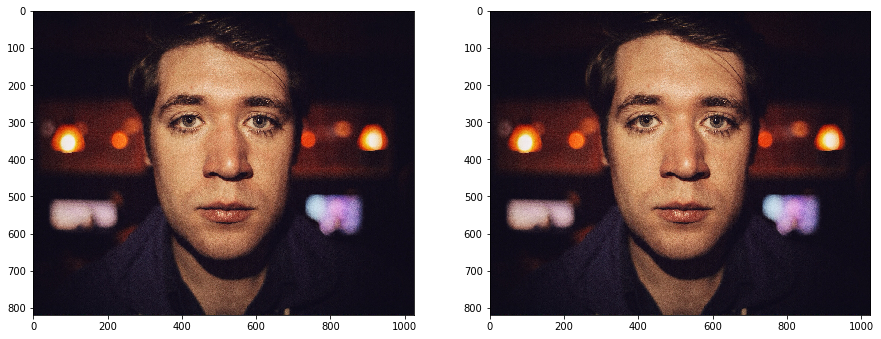

In [220]:
fig = plt.figure(figsize=(15,15))
fig.add_subplot(121)
plt.imshow(img)
fig.add_subplot(122)
plt.imshow(imgMorphNorm)
plt.show()

### Skin Segmentation by points

In [52]:
#new triangulation
pts_src = dlib_pts
size = img.shape
rect = (0, 0, size[1], size[0])
subdiv = cv2.Subdiv2D(rect)
pts = []
for pt in pts_src:
    pts.append(tuple(pt))
for pt in pts:
    subdiv.insert(pt)
triang4mask = subdiv.getTriangleList()
triang4mask.shape

(112, 6)

In [53]:
matte = np.zeros(img.shape, dtype=np.float32)
for tr in triang4mask:
    x1, y1, x2, y2, x3, y3 = tr
    t = [(x1, y1), (x2, y2), (x3, y3)]
    r = cv2.boundingRect(np.float32([t]))
    cv2.fillConvexPoly(matte, np.int32(t), (1.0, 1.0, 1.0), 16, 0)
matte_bl = cv2.GaussianBlur(matte, (21,21), -1).clip(0,1)

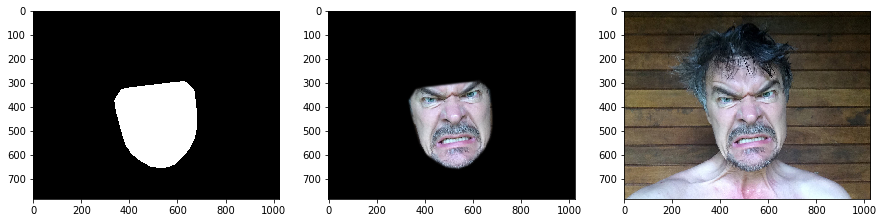

In [54]:
fig = plt.figure(figsize=(15,15))
plt.subplot(131)
plt.imshow(matte)
plt.subplot(132)
plt.imshow((img*matte_bl).clip(0,255).astype(np.uint8))
plt.subplot(133)
plt.imshow(img)
plt.show()

### NN segmentation

In [24]:
from keras.models import Sequential, Model
from keras.layers import *
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import relu
from keras.initializers import RandomNormal
from keras.applications import *
import keras.backend as K

from FCN8s_keras import FCN

Using TensorFlow backend.


In [25]:
model = FCN()
model.load_weights("Keras_FCN8s_face_seg_YuvalNirkin.h5")

In [26]:
def vgg_preprocess(im):
    im = cv2.resize(im, (500, 500))
    in_ = np.array(im, dtype=np.float32)
    in_ = in_[:,:,::-1]
    in_ -= np.array((104.00698793,116.66876762,122.67891434))
    in_ = in_[np.newaxis,:]
    #in_ = in_.transpose((2,0,1))
    return in_
  
def auto_downscaling(im):
    w = im.shape[1]
    h = im.shape[0]
    while w*h >= 700*700:
        im = cv2.resize(im, (0,0), fx=0.5, fy=0.5)
        w = im.shape[1]
        h = im.shape[0]
    return im

In [27]:
HAAR_CASCADE_FILEPATH = 'haarcascade_frontalface_default.xml'
cascade = cv2.CascadeClassifier(HAAR_CASCADE_FILEPATH)

In [28]:
def get_face_bbox(image):
    image = np.asarray(image)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    faces = cascade.detectMultiScale(gray, 1.3, 5)
    if not len(faces):
        return None
    x, y, w, h = faces[0]
    return x, y, x + w, y + h

def get_face_image(image):
    bbox = get_face_bbox(image)
    image = image.crop(bbox)
    image = image.resize((128, 128), Image.BICUBIC)
    image = image.convert("RGB")
    return image, bbox

In [29]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(100,100))

In [166]:
h, w, d = img.shape
bbox = get_face_bbox(img)
if bbox is not None:
    x1, y1, x2, y2 = bbox
    im = img[max(0,y1-50):min(y2+50,h), max(0,x1-30):min(x2+30,w)]
inp_im = vgg_preprocess(im)
out = model.predict([inp_im])
out_resized = cv2.resize(np.squeeze(out), (im.shape[1],im.shape[0]))
out_resized_clipped = np.clip(out_resized.argmax(axis=2), 0, 1).astype(np.float64)
mask = np.zeros((h,w,1))
mask[max(0,y1-50):min(y2+50,h), max(0,x1-30):min(x2+30,w),:] = out_resized_clipped[:,:,np.newaxis]

In [56]:
better_mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)[:,:,np.newaxis]
# better_mask = mask
masked = (mask*img.astype(np.float64)).astype(np.uint8)
masked_better = (better_mask*img.astype(np.float64)).astype(np.uint8)

In [57]:
mask2 = np.logical_or(matte,better_mask).astype(np.float32)
mask3 = np.logical_or(matte,mask).astype(np.float32)
mask2_bl = cv2.GaussianBlur(mask2, (21,21), -1).clip(0,1)
mask3_bl = cv2.GaussianBlur(mask3, (21,21), -1).clip(0,1)
better_mask_bl = cv2.GaussianBlur(better_mask, (21,21), -1).clip(0,1)[:,:,np.newaxis]
mask_bl = cv2.GaussianBlur(mask, (21,21), -1).clip(0,1)[:,:,np.newaxis]

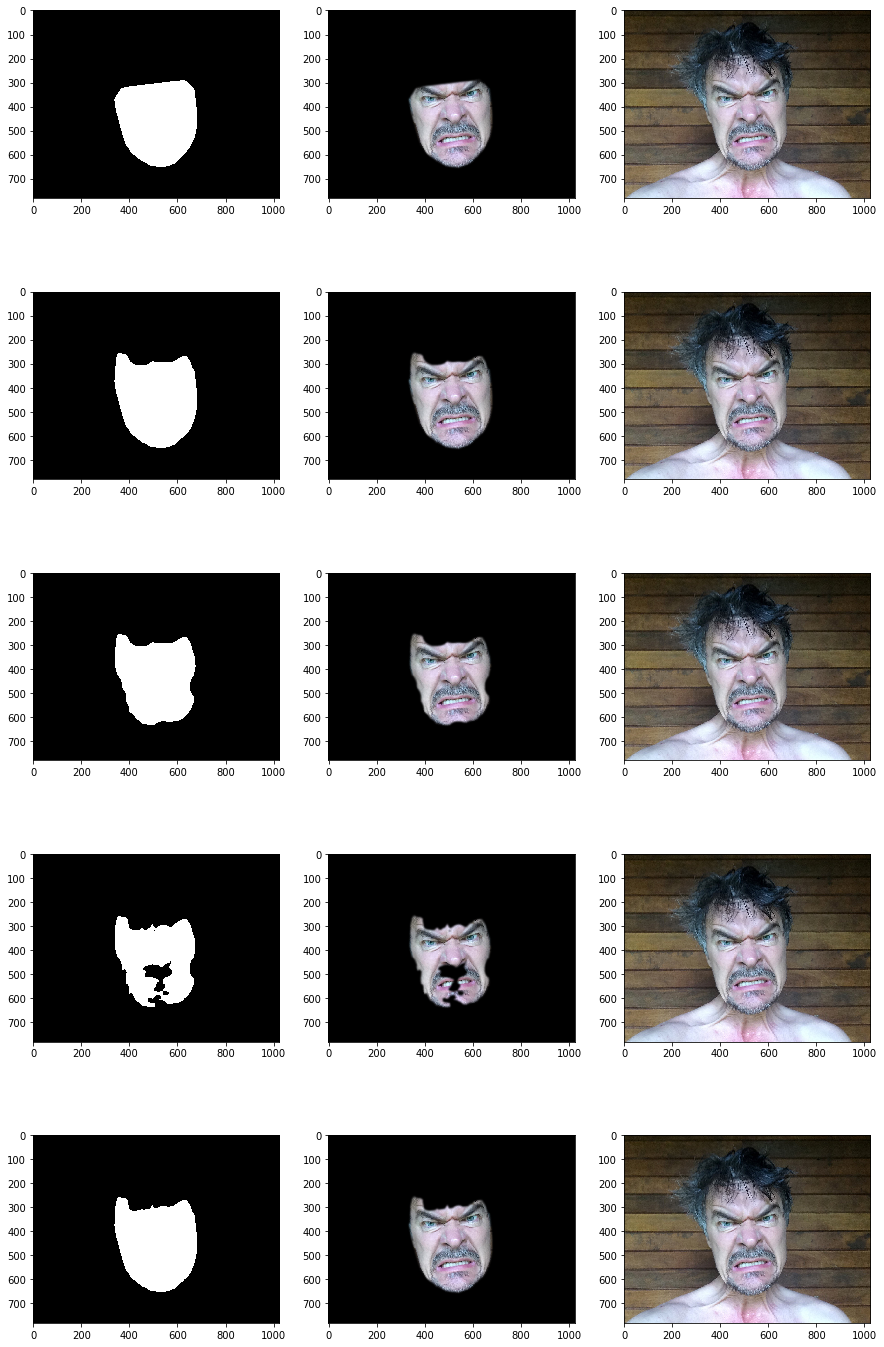

In [58]:
fig = plt.figure(figsize=(15,25))
plt.subplot(531)
plt.imshow(matte)
plt.subplot(532)
plt.imshow((img*matte_bl).clip(0,255).astype(np.uint8))
plt.subplot(533)
plt.imshow(img)
plt.subplot(534)
plt.imshow(mask2)
plt.subplot(535)
plt.imshow((img*mask2_bl).clip(0,255).astype(np.uint8))
plt.subplot(536)
plt.imshow(img)
plt.subplot(537)
plt.imshow(better_mask.squeeze(), cmap='gray')
plt.subplot(538)
plt.imshow((img*better_mask_bl).clip(0,255).astype(np.uint8))
plt.subplot(539)
plt.imshow(img)
plt.subplot(5,3,10)
plt.imshow(mask.squeeze(), cmap='gray')
plt.subplot(5,3,11)
plt.imshow((img*mask_bl).clip(0,255).astype(np.uint8))
plt.subplot(5,3,12)
plt.imshow(img)
plt.subplot(5,3,13)
plt.imshow(mask3.squeeze(), cmap='gray')
plt.subplot(5,3,14)
plt.imshow((img*mask3_bl).clip(0,255).astype(np.uint8))
plt.subplot(5,3,15)
plt.imshow(img)
plt.show()

### Extract hairline

In [178]:
contour = find_contours(mask[:,:,0], 0.5)[0].astype(np.int16)
contour = contour[np.logical_or(np.logical_and(contour[:,0]<pts[0][1],np.abs(contour[:,1] - pts[0][0])<=np.abs(contour[:,1] - pts[16][0])),
                                np.logical_and(contour[:,0]<pts[16][1],np.abs(contour[:,1] - pts[0][0])>np.abs(contour[:,1] - pts[16][0])))]
# contour = contour[np.abs(contour[:,1] - pts[0][0])<np.abs(contour[:,1] - pts[16][0])]
contour.shape

(853, 2)

In [179]:
contour = contour[np.linspace(0, len(contour)-1, num=9, endpoint=True).astype(np.uint16)][1:-1]

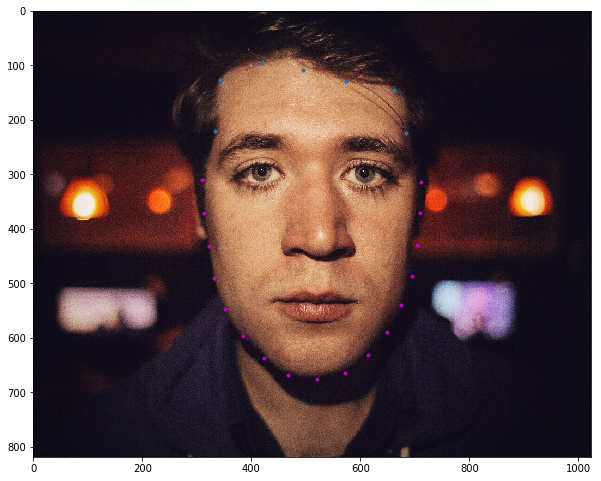

In [207]:
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.scatter(contour[:, 1], contour[:, 0], marker='.')
plt.scatter(dlib_pts[:17,0], dlib_pts[:17,1], marker='.', c='m')
plt.show()

In [173]:
pts[0], pts[16]

((219, 501), (461, 569))

In [110]:
contour[:,1].min(), contour[:,1].max()

(339, 667)

### Extract eyes and mouth

In [38]:
#eye tiangulation
pts_src = dlib_pts
size = img.shape
rect = (0, 0, size[1], size[0])
subdiv = cv2.Subdiv2D(rect)
pts = []
for pt in pts_src:
    pts.append(tuple(pt))
for i in range(36,42):
    subdiv.insert(pts[i])
triang4leye = subdiv.getTriangleList()
triang4leye.shape

(4, 6)

In [39]:
leye_mask = np.zeros(img.shape, dtype=np.float32)
for tr in triang4leye:
    x1, y1, x2, y2, x3, y3 = tr
    t = [(x1, y1), (x2, y2), (x3, y3)]
    r = cv2.boundingRect(np.float32([t]))
    cv2.fillConvexPoly(leye_mask, np.int32(t), (1.0, 1.0, 1.0), 16, 0)

In [40]:
#eye tiangulation
pts_src = dlib_pts
size = img.shape
rect = (0, 0, size[1], size[0])
subdiv = cv2.Subdiv2D(rect)
pts = []
for pt in pts_src:
    pts.append(tuple(pt))
for i in range(42,48):
    subdiv.insert(pts[i])
triang4reye = subdiv.getTriangleList()
triang4reye.shape

(4, 6)

In [41]:
reye_mask = np.zeros(img.shape, dtype=np.float32)
for tr in triang4reye:
    x1, y1, x2, y2, x3, y3 = tr
    t = [(x1, y1), (x2, y2), (x3, y3)]
    r = cv2.boundingRect(np.float32([t]))
    cv2.fillConvexPoly(reye_mask, np.int32(t), (1.0, 1.0, 1.0), 16, 0)

In [42]:
#mouth tiangulation
pts_src = dlib_pts
size = img.shape
rect = (0, 0, size[1], size[0])
subdiv = cv2.Subdiv2D(rect)
pts = []
for pt in pts_src:
    pts.append(tuple(pt))
for i in lips_left_idx:
    subdiv.insert(pts[i])
triang4llips = subdiv.getTriangleList()
triang4llips.shape

(11, 6)

In [43]:
llips_mask = np.zeros(img.shape, dtype=np.float32)
for tr in triang4llips:
    x1, y1, x2, y2, x3, y3 = tr
    t = [(x1, y1), (x2, y2), (x3, y3)]
    r = cv2.boundingRect(np.float32([t]))
    cv2.fillConvexPoly(llips_mask, np.int32(t), (1.0, 1.0, 1.0), 16, 0)

In [44]:
#mouth tiangulation
pts_src = dlib_pts
size = img.shape
rect = (0, 0, size[1], size[0])
subdiv = cv2.Subdiv2D(rect)
pts = []
for pt in pts_src:
    pts.append(tuple(pt))
for i in lips_right_idx:
    subdiv.insert(pts[i])
triang4rlips = subdiv.getTriangleList()
triang4rlips.shape

(13, 6)

In [45]:
rlips_mask = np.zeros(img.shape, dtype=np.float32)
for tr in triang4rlips:
    x1, y1, x2, y2, x3, y3 = tr
    t = [(x1, y1), (x2, y2), (x3, y3)]
    r = cv2.boundingRect(np.float32([t]))
    cv2.fillConvexPoly(rlips_mask, np.int32(t), (1.0, 1.0, 1.0), 16, 0)

In [46]:
eyes_mask = np.logical_or(leye_mask, reye_mask).astype(np.float32)
lips_mask = np.logical_or(llips_mask, rlips_mask).astype(np.float32)
eyeslips_mask = np.logical_or(eyes_mask, lips_mask).astype(np.float32)

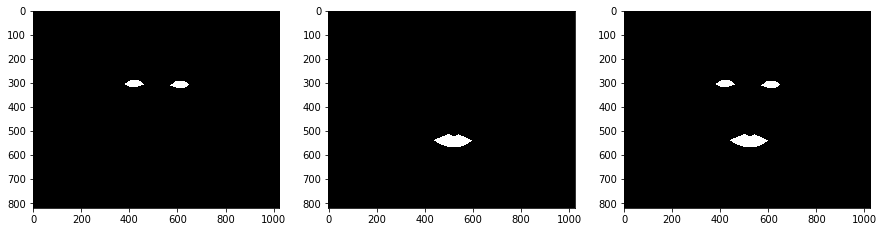

In [47]:
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(eyes_mask)
plt.subplot(132)
plt.imshow(lips_mask)
plt.subplot(133)
plt.imshow(eyeslips_mask)
plt.show()

In [48]:
skin_mask = np.logical_and(mask3, 1-eyeslips_mask).astype(np.float32)
skin_mask_bl = cv2.GaussianBlur(skin_mask, (21,21), -1).clip(0,1)

### Bilateral filtering

In [49]:
face = (img * skin_mask_bl).astype(np.uint8)
face_sm = cv2.bilateralFilter(face, 5, 50, 50)
face_sm_hard = cv2.bilateralFilter(face, 5, 250, 250)

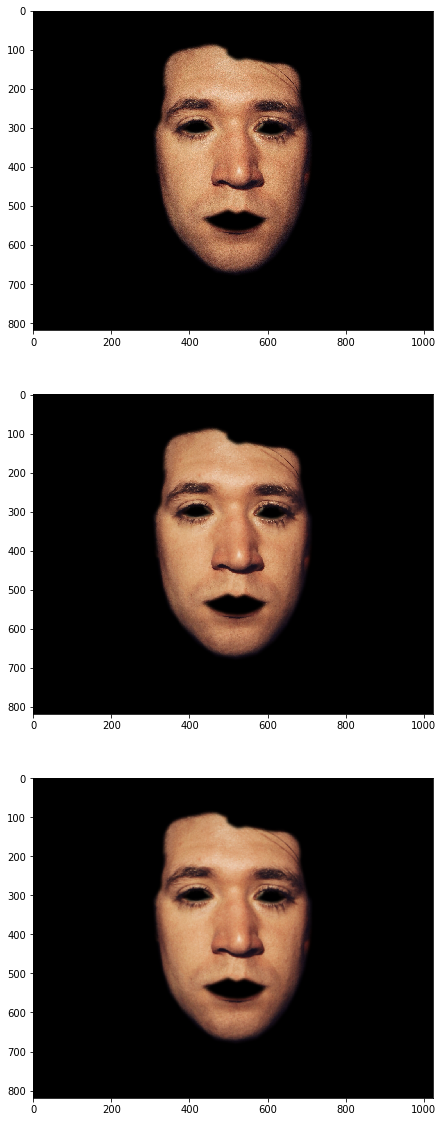

In [50]:
plt.figure(figsize=(20,20))
plt.subplot(311)
plt.imshow(face)
plt.subplot(312)
plt.imshow(face_sm)
plt.subplot(313)
plt.imshow(face_sm_hard)
plt.show()

In [51]:
img_sm = (img * (1-skin_mask_bl) + face_sm_hard).clip(0,255).astype(np.uint8)

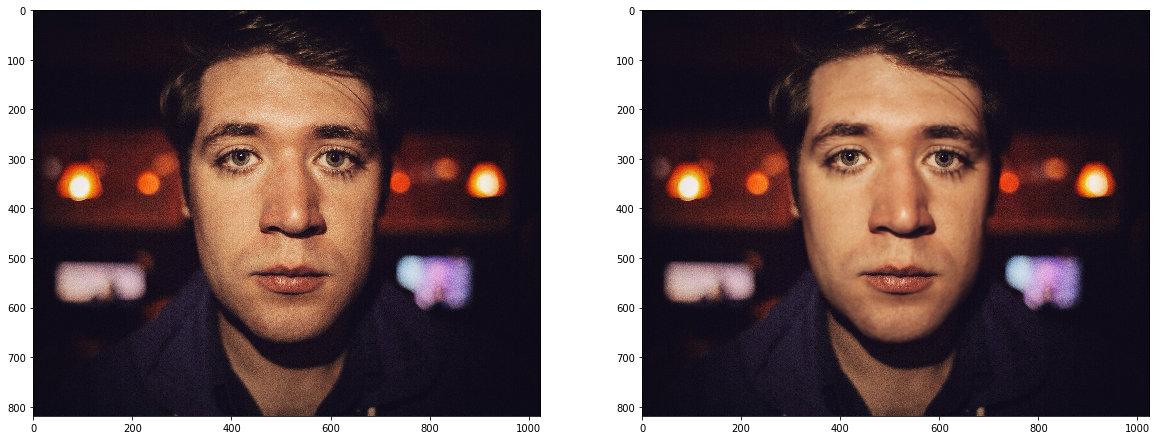

In [52]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(img_sm)
plt.show()

### Skin tone

In [53]:
from skimage.color import rgb2hsv, hsv2rgb, rgb2yuv, yuv2rgb

In [54]:
mask3_bl = cv2.GaussianBlur(mask3, (151,151), -1).clip(0,1)
skin_mask_bl = mask3_bl - cv2.GaussianBlur(eyeslips_mask, (31,31), -1).clip(0,1)

In [55]:
img_hsv = rgb2hsv(img)
img_hsv[:,:,1] -= 20/255

In [56]:
img1 = hsv2rgb(img_hsv)*255
img_tone = (img * (1-skin_mask_bl) + img1 * skin_mask_bl).clip(0,255).astype(np.uint8)

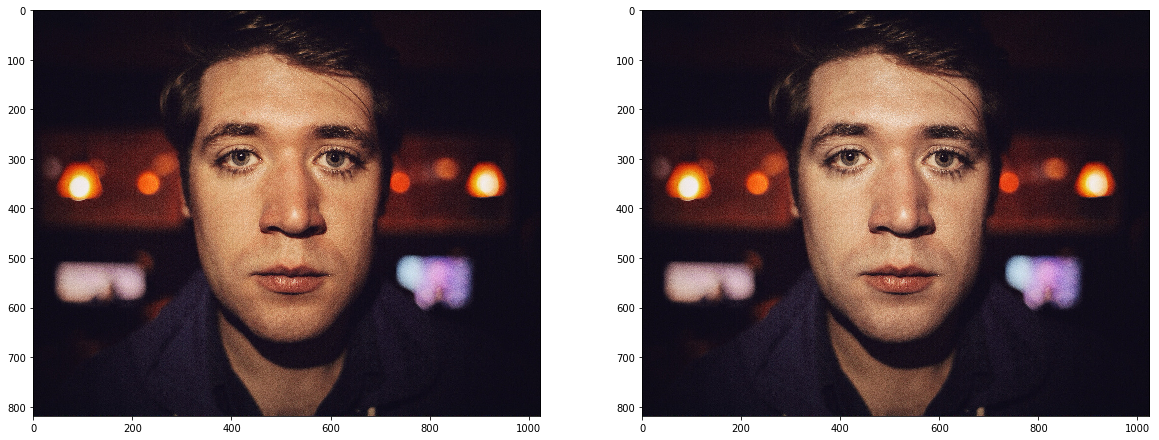

In [57]:
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(img_tone)
plt.show()

In [58]:
lips_mask_bl = cv2.GaussianBlur(lips_mask, (31,31), -1).clip(0,1)

In [59]:
img_hsv = rgb2hsv(img_tone)
img_hsv[:,:,1] -= 20/255

In [60]:
img1 = hsv2rgb(img_hsv)*255
img_tone_lips = (img_tone * (1-lips_mask_bl) + img1 * lips_mask_bl).clip(0,255).astype(np.uint8)

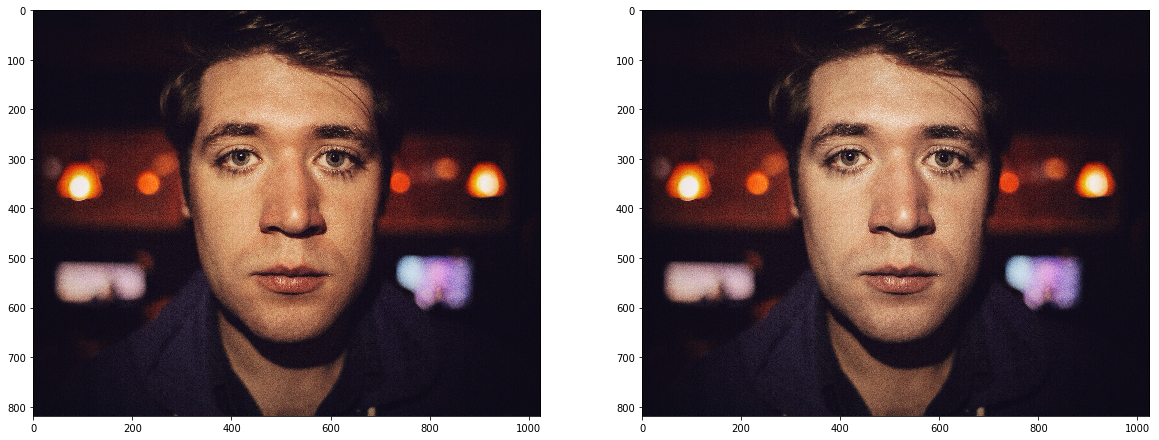

In [61]:
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(img_tone_lips)
plt.show()

### Skin hue?

In [462]:
tan = [150,100,70]
tan_show = np.tile(tan, (3,3,1))

In [463]:
img1 = np.float32(img.copy())
facecolorR = int((img1[:,:,0]*skin_mask[:,:,0]).sum() / np.count_nonzero(img1[:,:,0]*skin_mask[:,:,0]))
facecolorG = int((img1[:,:,1]*skin_mask[:,:,0]).sum() / np.count_nonzero(img1[:,:,1]*skin_mask[:,:,0]))
facecolorB = int((img1[:,:,2]*skin_mask[:,:,0]).sum() / np.count_nonzero(img1[:,:,2]*skin_mask[:,:,0]))
facecolor = [facecolorR, facecolorG, facecolorB]
facecolor_show = np.tile(facecolor, (3,3,1))

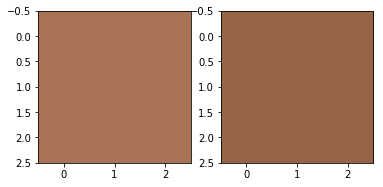

In [464]:
plt.subplot(121)
plt.imshow(facecolor_show)
plt.subplot(122)
plt.imshow(tan_show)
plt.show()

In [465]:
colorshift = np.array(tan) - np.array(facecolor)

In [466]:
img1 = np.float32(img.copy()) + 0.7*colorshift
img_color = (img * (1-skin_mask_bl) + img1 * skin_mask_bl).clip(0,255).astype(np.uint8)

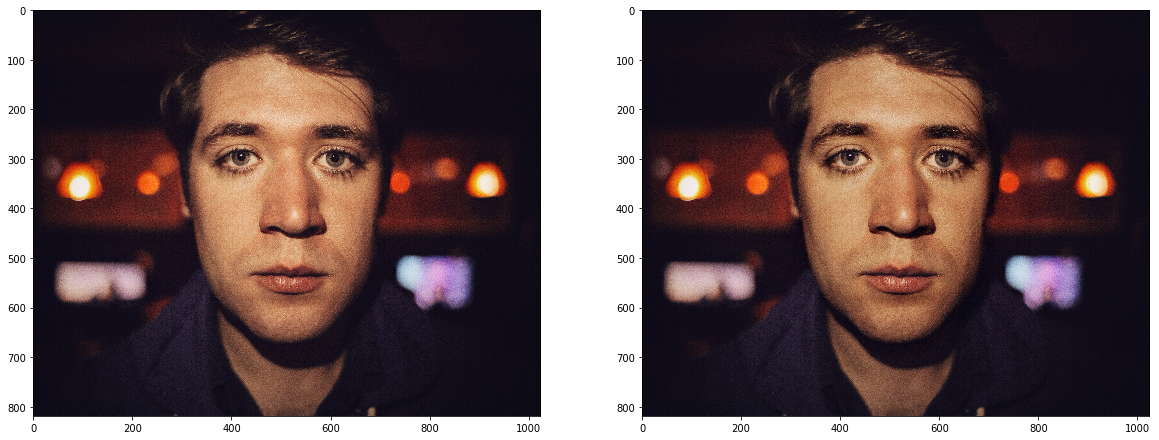

In [467]:
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(img_color)
plt.show()

### Contrast

In [87]:
from skimage.exposure import equalize_hist, equalize_adapthist

In [63]:
def faceHW(mask):
    pts = np.argwhere(mask)
    return pts[:,0].max() - pts[:,0].min(), pts[:,1].max() - pts[:,1].min()

In [88]:
img1 = np.float32(img.copy())
facemask = mask3[:,:,0].astype(np.bool)
faceH, faceW = faceHW(facemask)
faceH, faceW

(587, 402)

In [89]:
img_skcla = (equalize_adapthist(img, kernel_size=(faceH/5,faceW/3), clip_limit=0.005)*255).clip(0,255).astype(np.uint8)
img_contr  = (img * (1-mask3_bl) + img_skcla * mask3_bl).clip(0,255).astype(np.uint8)

/home/yury/anaconda3/envs/ml/lib/python3.6/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


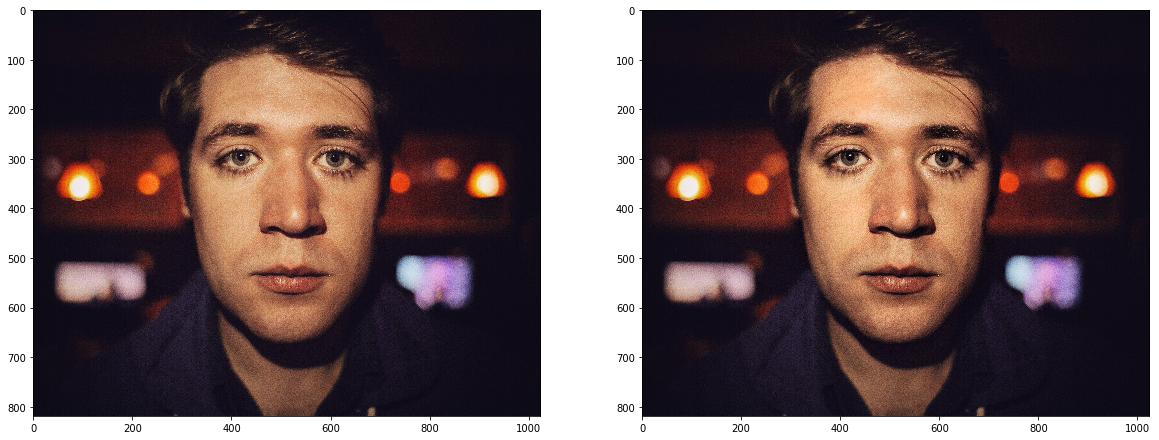

In [90]:
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(img_contr)
plt.show()

### Wrinkles etc

In [430]:
from skimage import filters

In [451]:
lap = filters.sobel(0.299*img[:,:,0] + 0.587*img[:,:,1] + 0.114*img[:,:,2])
lap.min(), lap.max()

(0.0, 165.9727067135211)

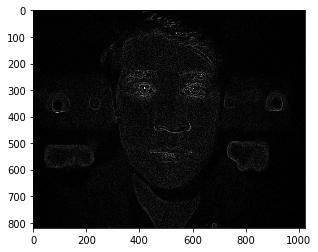

In [453]:
plt.imshow(lap, cmap='gray')

### Sandbox

In [76]:
a = np.array([[1,2],
              [3,4],
              [5,6],
              [7,8],
              [9,10]])

In [80]:
a[np.abs(a[:,1]-4) >= np.abs(a[:,1]-8)]

array([[ 5,  6],
       [ 7,  8],
       [ 9, 10]])